# Import Necessary Libraries

In [78]:
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scipy as sp
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 300)

# Read Training-Set into a DataFrame

In [79]:
df = pd.read_csv('kc_house_data_train.csv')

In [80]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [81]:
df.tail()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17285,17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028
17289,17289,6703100135,20150116T000000,348000.0,3,1.50,1330,6768,1.0,0,0,4,7,1330,0,1952,0,98155,47.7366,-122.319,1320,6910


In [82]:
df['age'] = 2020 - df['yr_built']

- Making the date column a date-time object

In [83]:
list_of_dates = [(date[:4]+"-"+date[4:6]+"-"+date[6:8]) for date in df['date']]

In [84]:
df['date'] = [datetime.strptime(list_of_dates[date], '%Y-%m-%d') for date in range(len(df['date']))]

In [85]:
type(df['date'][5])

pandas._libs.tslibs.timestamps.Timestamp

- Remove erroneous values in bedroom column

In [9]:
df['bedrooms'].value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [10]:
df.shape

(17290, 23)

In [11]:
df.loc[8597,'bedrooms'] = 3

In [12]:
df.loc[8597,'bedrooms']

3

In [13]:
df['beds_to_baths'] = df['bedrooms']/df['bathrooms']

In [14]:
df['bathrooms'].value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

In [15]:
for i in df[df['bathrooms'] == 0].index:
    df.drop(i, inplace=True)

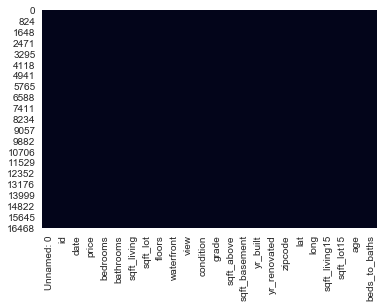

In [16]:
sns.heatmap(df.isnull(), cbar=False)

In [17]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [18]:
df['year_sold'] = [date.year for date in df['date']]
df['month_sold'] = [date.month for date in df['date']]
year_dict = {2014:1, 2015:2}
df['year_sold'].replace(year_dict, inplace=True)

In [19]:
df.year_sold.unique()

array([1, 2])

In [20]:
df.month_sold.unique()

array([10,  8,  3,  7,  5,  4,  1,  6,  2,  9, 11, 12])

In [21]:
df['year_month_sold'] = df['year_sold']*df['month_sold']
df['year_month_sold'].value_counts()

8     3364
6     3247
10    1998
7     1761
5     1423
9     1386
12    1169
11    1154
4      988
2      792
Name: year_month_sold, dtype: int64

In [22]:
lr_model = ols(formula='price~bedrooms+year_sold+sqft_living+sqft_lot+floors+waterfront+condition', data=df).fit()

In [23]:

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     3092.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:33:47   Log-Likelihood:            -2.3923e+05
No. Observations:               17282   AIC:                         4.785e+05
Df Residuals:                   17274   BIC:                         4.785e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.505e+05   1.53e+04     -9.823      0.000   -1.81e+05    -1.2e+05
bedrooms     -5.92e+04   2605.856    -22.719      0.000   -6.43e+04   -5.41e+04
year_sold    2.186e+04   4054.929      5.392      0.000    1.39e+04    2.98e+04
sqft_living   313.0010      2.768    113.093      0.000     307.576     318.426
sqft_lot       -0.3451      0.046     -7.560      0.000      -0.435      -0.256
floors       1.911e+04   3902.036      4.896      0.000    1.15e+04    2.68e+04
waterfront   7.925e+05   2.15e+04     36.879      0.000     7.5e+05    8.35e+05
condition    5.307e+04   3021.984     17.561      0.000    4.71e+04     5.9e+04
==============================================================================
Omnibus:                    11015.082   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           398231.291
Skew:                           2.527   Prob(JB):                         0.00
Kurtosis:                      25.967   Cond. No.                     5.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#lin_reg = LinearRegression()
#lin_reg.fit(X_train, y_train)
#y_pred = lin_reg.predict(X_test)
#print(metrics.mean_squared_error(y_test, y_pred))

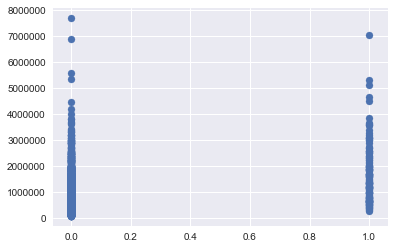

In [25]:
plt.scatter(df['waterfront'], df['price'])

In [26]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'beds_to_baths',
       'year_sold', 'month_sold', 'year_month_sold'],
      dtype='object')

# Test-Train Split
- Beginning of SKLearn

In [49]:
X = df[['bathrooms', 'bedrooms', 'year_sold', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']]
y = df[['price']]
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
scale = StandardScaler()
transformed_train = scale.fit_transform(X_train)
X_train = pd.DataFrame(transformed_train, columns = X_train.columns)
transformed_test = scale.transform(X_test)
X_test = pd.DataFrame(transformed_test, columns = X_train.columns)

Training Error: 146335.69830068768
Testing Error: 231151.73159097118


/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29919233503511.875, tolerance: 195786190456.41293
  positive)


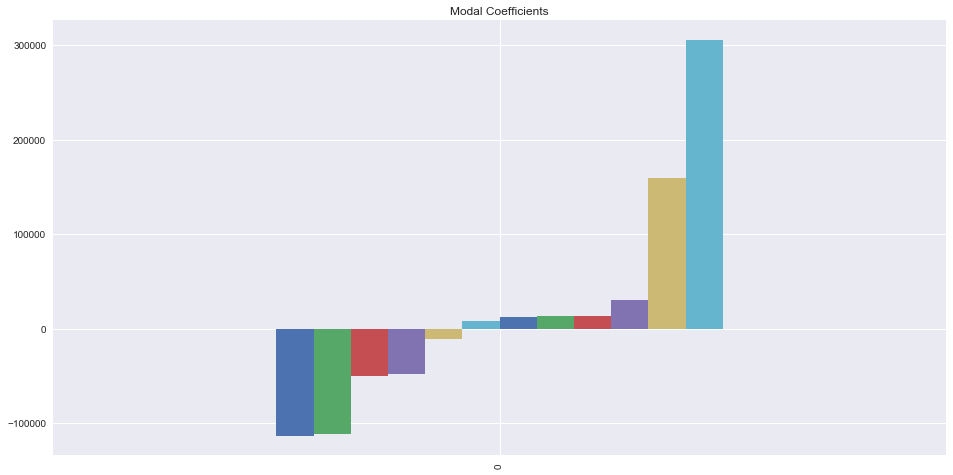

In [51]:
lasso = Lasso(alpha=0.1, normalize=False)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

#lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
#lasso_coef01.columns = X_train.columns
#lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
#lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [52]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
test_rmse/y_test.std()

price    0.640639
dtype: float64

In [44]:
X.corr()

,bathrooms,bedrooms,year_sold,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement
bathrooms,1.000000,0.522041,-0.029964,0.756713,0.085667,0.500280,0.065848,-0.124292,0.665441,0.688634,0.282384
bedrooms,0.522041,1.000000,-0.010100,0.590291,0.030767,0.182088,-0.008835,0.020022,0.366870,0.490435,0.307711
year_sold,-0.029964,-0.010100,1.000000,-0.033487,0.003134,-0.024752,-0.000819,-0.044933,-0.036498,-0.030818,-0.011852
sqft_living,0.756713,0.590291,-0.033487,1.000000,0.166943,0.357114,0.109790,-0.061875,0.763084,0.876574,0.435746
sqft_lot,0.085667,0.030767,0.003134,0.166943,1.000000,-0.002040,0.015358,-0.013705,0.110654,0.180916,0.008077
floors,0.500280,0.182088,-0.024752,0.357114,-0.002040,1.000000,0.025186,-0.259399,0.459522,0.528551,-0.247446
waterfront,0.065848,-0.008835,-0.000819,0.109790,0.015358,0.025186,1.000000,0.009578,0.092365,0.077218,0.083414
condition,-0.124292,0.020022,-0.044933,-0.061875,-0.013705,-0.259399,0.009578,1.000000,-0.143608,-0.157827,0.166771
grade,0.665441,0.366870,-0.036498,0.763084,0.110654,0.459522,0.092365,-0.143608,1.000000,0.758440,0.165051
sqft_above,0.688634,0.490435,-0.030818,0.876574,0.180916,0.528551,0.077218,-0.157827,0.758440,1.000000,-0.051211


In [53]:
test_rmse

231151.73159097118

In [59]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [62]:
y_pred_bayes = reg.predict(X_test)

In [64]:
bayes_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_bayes))
print(bayes_rmse)
bayes_rmse_std = bayes_rmse/y_test.std()
print(bayes_rmse_std)

231149.69643901783
price    0.640633
dtype: float64


In [65]:
features = ['bathrooms', 'bedrooms', 'year_sold', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
#instantiate this class
poly_2 = PolynomialFeatures(degree=2, interaction_only=False)
#fit and transform the data and create a  new dataframe
df_poly = pd.DataFrame(poly_2.fit_transform(X), columns=poly_2.get_feature_names(X.columns))
df_poly.head()

,1,bathrooms,bedrooms,year_sold,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,bathrooms^2,bathrooms bedrooms,bathrooms year_sold,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms condition,bathrooms grade,bathrooms sqft_above,bathrooms sqft_basement,bathrooms yr_built,bathrooms yr_renovated,bedrooms^2,bedrooms year_sold,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms yr_built,bedrooms yr_renovated,year_sold^2,year_sold sqft_living,year_sold sqft_lot,year_sold floors,year_sold condition,year_sold grade,year_sold sqft_above,year_sold sqft_basement,year_sold yr_built,year_sold yr_renovated,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living condition,sqft_living grade,sqft_living sqft_above,sqft_living sqft_basement,sqft_living yr_built,sqft_living yr_renovated,sqft_lot^2,sqft_lot floors,sqft_lot condition,sqft_lot grade,sqft_lot sqft_above,sqft_lot sqft_basement,sqft_lot yr_built,sqft_lot yr_renovated,floors^2,floors condition,floors grade,floors sqft_above,floors sqft_basement,floors yr_built,floors yr_renovated,condition^2,condition grade,condition sqft_above,condition sqft_basement,condition yr_built,condition yr_renovated,grade^2,grade sqft_above,grade sqft_basement,grade yr_built,grade yr_renovated,sqft_above^2,sqft_above sqft_basement,sqft_above yr_built,sqft_above yr_renovated,sqft_basement^2,sqft_basement yr_built,sqft_basement yr_renovated,yr_built^2,yr_built yr_renovated,yr_renovated^2
0,1.0,2.25,4.0,1.0,2070.0,8893.0,2.0,4.0,8.0,2070.0,0.0,1986.0,0.0,5.0625,9.0,2.25,4657.5,20009.25,4.5,9.0,18.0,4657.5,0.0,4468.5,0.0,16.0,4.0,8280.0,35572.0,8.0,16.0,32.0,8280.0,0.0,7944.0,0.0,1.0,2070.0,8893.0,2.0,4.0,8.0,2070.0,0.0,1986.0,0.0,4284900.0,18408510.0,4140.0,8280.0,16560.0,4284900.0,0.0,4111020.0,0.0,79085449.0,17786.0,35572.0,71144.0,18408510.0,0.0,17661498.0,0.0,4.0,8.0,16.0,4140.0,0.0,3972.0,0.0,16.0,32.0,8280.0,0.0,7944.0,0.0,64.0,16560.0,0.0,15888.0,0.0,4284900.0,0.0,4111020.0,0.0,0.0,0.0,0.0,3944196.0,0.0,0.0
1,1.0,3.00,5.0,1.0,2900.0,6730.0,1.0,5.0,8.0,1830.0,1070.0,1977.0,0.0,9.0000,15.0,3.00,8700.0,20190.00,3.0,15.0,24.0,5490.0,3210.0,5931.0,0.0,25.0,5.0,14500.0,33650.0,5.0,25.0,40.0,9150.0,5350.0,9885.0,0.0,1.0,2900.0,6730.0,1.0,5.0,8.0,1830.0,1070.0,1977.0,0.0,8410000.0,19517000.0,2900.0,14500.0,23200.0,5307000.0,3103000.0,5733300.0,0.0,45292900.0,6730.0,33650.0,53840.0,12315900.0,7201100.0,13305210.0,0.0,1.0,5.0,8.0,1830.0,1070.0,1977.0,0.0,25.0,40.0,9150.0,5350.0,9885.0,0.0,64.0,14640.0,8560.0,15816.0,0.0,3348900.0,1958100.0,3617910.0,0.0,1144900.0,2115390.0,0.0,3908529.0,0.0,0.0
2,1.0,2.50,4.0,1.0,3770.0,10893.0,2.0,3.0,11.0,3770.0,0.0,1997.0,0.0,6.2500,10.0,2.50,9425.0,27232.50,5.0,7.5,27.5,9425.0,0.0,4992.5,0.0,16.0,4.0,15080.0,43572.0,8.0,12.0,44.0,15080.0,0.0,7988.0,0.0,1.0,3770.0,10893.0,2.0,3.0,11.0,3770.0,0.0,1997.0,0.0,14212900.0,41066610.0,7540.0,11310.0,41470.0,14212900.0,0.0,7528690.0,0.0,118657449.0,21786.0,32679.0,119823.0,41066610.0,0.0,21753321.0,0.0,4.0,6.0,22.0,7540.0,0.0,3994.0,0.0,9.0,33.0,11310.0,0.0,5991.0,0.0,121.0,41470.0,0.0,21967.0,0.0,14212900.0,0.0,7528690.0,0.0,0.0,0.0,0.0,3988009.0,0.0,0.0
3,1.0,3.50,3.0,2.0,4560.0,14608.0,2.0,3.0,12.0,4560.0,0.0,1990.0,0.0,12.2500,10.5,7.00,15960.0,51128.00,7.0,10.5,42.0,15960.0,0.0,6965.0,0.0,9.0,6.0,13680.0,43824.0,6.0,9.0,36.0,13680.0,0.0,5970.0,0.0,4.0,9120.0,29216.0,4.0,6.0,24.0,9120.0,0.0,3980.0,0.0,20793600.0,66612480.0,9120.0,13680.0,54720.0,20793600.0,0.0,9074400.0,0.0,213393664.0,29216.0,43824.0,175296.0,66612480.0,0.0,29069920.0,0.0,4.0,6.0,24.0,9120.0,0.0,3980.0,0.0,9.0,36.0,13680.0,0.0,5970.0,0.0,144.0,54720.0,0.0,23880.0,0.0,20793600.0,0.0,9074400.0,0.0,0.0,0.0,0.0,3960100.0,0.0,0.0
4,1.0,2.50,3.0,1.0,2550.0,5376.0,2.0,3.0,9.0,2550.0,0.0,2004.0,0.0,6.2500,7.5,2.50,6375.0,13440.00,5.0,7.5,22.5,6375.0,0.0,5010.0,0.0,9.0,3.0,7650.0,16128.0,6.0,9.0,27.0,7650.0,0.0,6012.

In [66]:
X_train , X_test, y_train, y_test = train_test_split(df_poly, y, test_size=0.2, random_state=0)

In [67]:
scale = StandardScaler()
transformed_train = scale.fit_transform(X_train)
X_train = pd.DataFrame(transformed_train, columns = X_train.columns)
transformed_test = scale.transform(X_test)
X_test = pd.DataFrame(transformed_test, columns = X_train.columns)

In [70]:
lasso = Lasso(alpha=0.01, normalize=False, max_iter=10000)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 132386.17588960277
Testing Error: 199474.5638403347


/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292671620127785.2, tolerance: 195786190456.41293
  positive)


In [71]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
test_rmse/y_test.std()

price    0.552845
dtype: float64

In [72]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
y_pred_bayes = reg.predict(X_test)
bayes_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_bayes))
print(bayes_rmse)
bayes_rmse_std = bayes_rmse/y_test.std()
print(bayes_rmse_std)

200605.7415811137
price    0.55598
dtype: float64


/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
